# Debug GestureNet OpenCL implement with PyOpenCL and PyTorch
Partial code are copied heavily from https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py  
SqueezeNet Paper:https://arxiv.org/abs/1602.07360  
SqueezeNet 1.1 model from https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1   
SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters than SqueezeNet 1.0, without sacrificing accuracy.


In [1]:
#some set up
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import math
import time
from torchsummary import summary
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

## Test top-1 accuracy on pytorch pre-trained SqueezeNet v1.1 

### Build GestureNet model for Accelerometer

In [2]:
class GestureAccelNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GestureAccelNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,32,kernel_size=1,stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,13,kernel_size=1,stride=1),
            nn.ReLU(inplace=True)
            )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(13,self.num_classes,kernel_size=1,stride=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d((16,3), stride=1)
        )

    def forward(self, x):
        x = self.features(x)
        #print(x)
        x = self.classifier(x)
        #return x
        return x.view(x.size(0), self.num_classes)

In [3]:
model = GestureAccelNet()
print(model)

GestureAccelNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 13, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(13, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=(16, 3), stride=1, padding=0)
  )
)


In [4]:
summary(model,input_size=(1,16,3), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 64, 16, 3]             128
              ReLU-2             [1, 64, 16, 3]               0
            Conv2d-3             [1, 32, 16, 3]           2,080
              ReLU-4             [1, 32, 16, 3]               0
            Conv2d-5             [1, 13, 16, 3]             429
              ReLU-6             [1, 13, 16, 3]               0
           Dropout-7             [1, 13, 16, 3]               0
            Conv2d-8              [1, 2, 16, 3]              28
              ReLU-9              [1, 2, 16, 3]               0
        AvgPool2d-10               [1, 2, 1, 1]               0
Total params: 2,665
Trainable params: 2,665
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total

### Load  Dataset

In [5]:
classes = ['4_slow_swipe','9_circle']
y_train = [0,1]
x_train = np.zeros(shape=(1,16,3))
global datidx, labidx
datidx = 0
labidx = 0

In [6]:
from torch.utils.data import Dataset,DataLoader
class acceldataset(Dataset):
    def __init__(self, data, target):
        self.x_train = data
        self.y_train = target
    def __len__(self):
        return len(self.y_train)
    def __getitem__(self,idx):
        global datidx, labidx
        #print(y_train[idx])
        datidx+=1
        labidx+=1
        if datidx == 10:
            datidx = 0
        if labidx == 2:
            labidx = 0
        # index = np.random.randint(2,size=1)[0]
        x_train=np.zeros(shape=(1,16,3))
        # fileidx = np.random.randint(10,size=1)[0]
        data=pd.read_csv('acceldataset/'+classes[labidx]+'/'+str(datidx)+'.csv')
        for i in range(0, 16):
            x_train[0][i][0] = data["wristX"][i]
            x_train[0][i][1] = data["wristY"][i]
            x_train[0][i][2] = data["wristZ"][i]
        #preprocess data
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                                std = [ 0.5, 0.5, 0.5 ]),
        ])
        self.x_train = transform(x_train)
        self.x_train = torch.reshape(self.x_train,(1,16,3))
        #print(self.x_train.shape)
        return self.x_train,self.y_train[labidx]

In [7]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=1000)

In [8]:
dataset = acceldataset(data,target)
len(dataset)

1000

In [9]:
train_loader = DataLoader(dataset=dataset, batch_size=200, shuffle=True)

### Training Neural Network

In [10]:
train_losses = []
accuracylist = []
# Training and Testing Model
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       train_loss = 0
       correct = 0
       # Iterate over data.
       for features, labels in train_loader:
           # Forward Pass
           #print(features.shape)
           output = model(features.float())
           loss = criterion(output, labels.long())
           optimizer.zero_grad() # clear previous gradients
           loss.backward() # backward pass
           optimizer.step()
           train_loss += loss.item()
           #print(np.argmax(output.detach().numpy(),axis=1))
           #print(labels.detach().numpy())
           correct += (np.argmax(output.detach().numpy(),axis=1) == labels.detach().numpy()).sum()
           print('{} Loss: {:.4f}'.format(
               'train', train_loss))
           train_losses.append(loss.item())
       accuracy = 100 * correct / len(dataset)
       accuracylist.append(accuracy)
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

In [11]:
# Define Hyper Parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_func = torch.nn.NLLLoss

In [12]:
gesturenet = train_model(model, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 1/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 2/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 3/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 4/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 5/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 6/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 7/24
----------
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
train Loss: 0.0000
Epoch 8/24
----------
train Loss: 0.0000
train Loss: 0.0000
trai

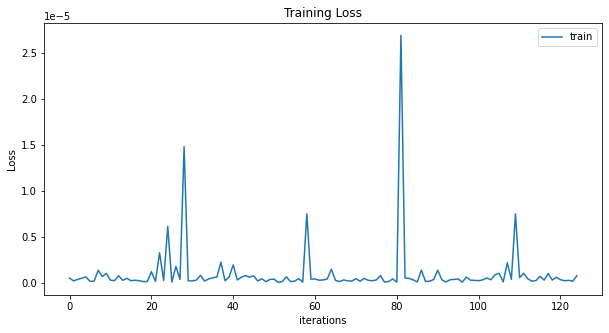

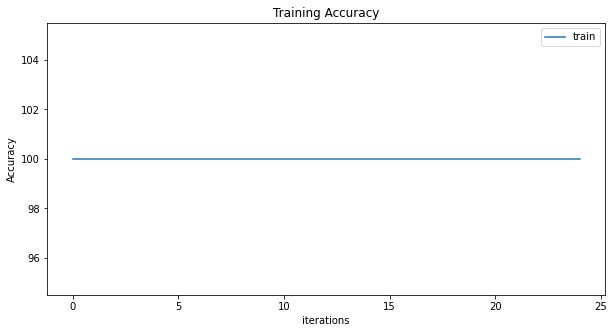

In [13]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(accuracylist,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
torch.save(model.state_dict(), 'GestureAccelNet.pth')

### Calculate top-1 accuracy of the pre-trained model

## Test Model in Pytorch if the OpenCL implement is correct
By comprare the result of OpenCL implement and PyTorch implement using a single image as input  
error = ((OpenCL_implement_class_socores - PyTorch_implement_class_socores) ^ 2).sum(element_wise)  
If the OpenCL implement is correct, error should be relativly small.

In [15]:
# load the test image
print(classes[0])
x_test=np.zeros(shape=(1,1,16,3))
data=pd.read_csv('acceldataset/'+classes[0]+'/'+str(1)+'.csv')
#print(len(data["wristX"]))
for i in range(0, 16):
    x_test[0][0][i][0] = data["wristX"][i]
    x_test[0][0][i][1] = data["wristY"][i]
    x_test[0][0][i][2] = data["wristZ"][i]
#preprocess data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                        std = [ 0.5, 0.5, 0.5 ]),
])
x_test = transform(x_test[0])
x_test = torch.reshape(x_test,(1,1,16,3))
print(x_test.shape)

4_slow_swipe
torch.Size([1, 1, 16, 3])


In [16]:
model.cpu()
y_test = model(x_test.float())
print(y_test)
_, predicted = torch.max(y_test.data, 1)
print(predicted)
print('the label index prediction of pytorch implement: '+classes[predicted])

tensor([[28.2092,  0.4800]], grad_fn=<ViewBackward0>)
tensor([0])
the label index prediction of pytorch implement: 4_slow_swipe


### Load OpenCL implement
deviceinfo.py and partial pyopencl code are from Hands On OpenCL  
https://handsonopencl.github.io/

#### Step1: OpenCL preparation

In [17]:
# OpenCL setup
import pyopencl as cl
import deviceinfo

In [18]:
# Ask the user to select a platform/device on the CLI
context = cl.create_some_context()

# Print out device info
deviceinfo.output_device_info(context.devices[0])

# Create a command queue
queue = cl.CommandQueue(context)

Device is NVIDIA GeForce GTX 1650 TiGPU from NVIDIA Corporation with a max of 16 compute units


#### Step 2: import parameters from pytorch implement

In [19]:
params = model.state_dict()
for k,v in params.items():
    # print parameter name
    print(k,params[k].numpy().shape)
conv1_weight = params['features.0.weight'].numpy().reshape(-1)
conv1_bias = params['features.0.bias'].numpy()
conv2_weight = params['features.2.weight'].numpy().reshape(-1)
conv2_bias = params['features.2.bias'].numpy()
conv3_weight = params['features.4.weight'].numpy().reshape(-1)
conv3_bias = params['features.4.bias'].numpy()
classifier_weight = params['classifier.1.weight'].numpy().reshape(-1)
classifier_bias = params['classifier.1.bias'].numpy()

features.0.weight (64, 1, 1, 1)
features.0.bias (64,)
features.2.weight (32, 64, 1, 1)
features.2.bias (32,)
features.4.weight (13, 32, 1, 1)
features.4.bias (13,)
classifier.1.weight (2, 13, 1, 1)
classifier.1.bias (2,)


In [20]:
params['classifier.1.bias'].dtype

torch.float32

Creat OpenCL memory object

In [21]:
h_sample = x_test.numpy().reshape(-1)
h_result_conv = np.empty(1 * 64 * 16 * 3).astype(np.float32)
h_result_conv2 = np.empty(1 * 32 * 16 * 3).astype(np.float32)
h_result_conv3 = np.empty(1 * 13 * 16 * 3).astype(np.float32)
h_result_classifier_conv = np.empty(1 * len(classes) * 16 * 3).astype(np.float32)
h_result_classifier = np.empty(1 * len(classes)).astype(np.float32)

# device input buffer
d_sample = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_sample)

# device buffers 
d_conv1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv1_weight)
d_conv1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv1_bias)
d_conv2_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv2_weight)
d_conv2_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv2_bias)
d_conv3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv3_weight)
d_conv3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=conv3_bias)
d_classifier_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_weight)
d_classifier_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_bias)

d_result_conv = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_conv.nbytes)
d_result_conv2 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_conv2.nbytes)
d_result_conv3 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_conv3.nbytes)
d_result_classifier_conv = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_classifier_conv.nbytes)
d_result_classifier = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_classifier.nbytes)

#### Step 3: create kernels
Create & build program

In [22]:
kernelSource = open("gesturenet.cl").read()
program = cl.Program(context, kernelSource).build()

Create kernels

In [23]:
conv3x3 = program.conv2d3x3
conv3x3.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, np.int32, np.int32, np.int32, \
                               None, None, None, None])

maxpool = program.maxpool2d
maxpool.set_scalar_arg_dtypes([np.int32, np.int32, None, None])

conv1x1 = program.conv2d1x1
conv1x1.set_scalar_arg_dtypes([np.int32, np.int32, np.int32,\
                               None, None, None, None])

avgpool = program.avgpool2d
avgpool.set_scalar_arg_dtypes([np.int32,np.int32,None, None])

fc = program.fc
fc.set_scalar_arg_dtypes([np.int32,np.int32,None,None,None,None])

Run OpenCL implement  

In [24]:
rtime = time.time()
print(conv1_weight.shape)
# First
conv1x1(queue,(64,), None, 1, 16, 3, d_sample, d_conv1_weight ,d_conv1_bias, d_result_conv)
# Second
conv1x1(queue,(32,), None, 64, 16, 3, d_result_conv, d_conv2_weight ,d_conv2_bias, d_result_conv2)
# Third
conv1x1(queue,(13,), None, 32, 16, 3, d_result_conv2, d_conv3_weight ,d_conv3_bias, d_result_conv3)
# classifier
conv1x1(queue,(len(classes),), None, 13, 16, 3, d_result_conv3, d_classifier_weight, d_classifier_bias, d_result_classifier_conv)
avgpool(queue,(len(classes),), None, 16, 3, d_result_classifier_conv, d_result_classifier)
# Wait for the commands to finish before reading back
queue.finish()
rtime = time.time() - rtime
print("The kernel ran in", rtime, "seconds")

(64,)
The kernel ran in 0.0019958019256591797 seconds


In [25]:
#copy result from gpu
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
queue.finish()
label_opencl = np.argmax(h_result_classifier)
print('the label index prediction of OpenCL implement: %d' % label_opencl)

correct_result = y_test.data.numpy().reshape(-1)
error = ((correct_result - h_result_classifier) ** 2).sum()
print('OpenCL implement error: ', error)
cl.enqueue_copy(queue, h_result_conv, d_result_conv)
print(h_result_conv.shape)
cl.enqueue_copy(queue, h_result_conv2, d_result_conv2)
print(h_result_conv2.shape)
cl.enqueue_copy(queue, h_result_conv3, d_result_conv3)
print(h_result_conv3.shape)
cl.enqueue_copy(queue, h_result_classifier_conv, d_result_classifier_conv)
print(h_result_classifier_conv.shape)
print(y_test)
print(h_result_classifier)

the label index prediction of OpenCL implement: 0
OpenCL implement error:  794.8723
(3072,)
(1536,)
(624,)
(96,)
tensor([[28.2092,  0.4800]], grad_fn=<ViewBackward0>)
[0.01978288 0.        ]
